In [0]:
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [0]:
# colab configuration

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load the preprocessed data, embedding matrix and word count

q1_data = np.load(open('/content/drive/My Drive/NLP/Data/q1_train.npy', 'rb'))
q2_data = np.load(open('/content/drive/My Drive/NLP/Data/q2_train.npy', 'rb'))
labels = np.load(open('/content/drive/My Drive/NLP/Data/label_train.npy', 'rb'))
word_embedding_matrix = np.load(open('/content/drive/My Drive/NLP/Data/word_embedding_matrix.npy', 'rb'))
with open('/content/drive/My Drive/NLP/Data/nb_words.json', 'r') as f:
    nb_words = json.load(f)['nb_words']

In [0]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

# LJ-LSTM Model Structure

In [0]:
question1 = Input(shape=(25,))
question2 = Input(shape=(25,))

q1 = Embedding(nb_words + 1, 
                 300, 
                 weights=[word_embedding_matrix], 
                 input_length=25, 
                 trainable=False)(question1)

q1 = Bidirectional(LSTM(128, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1, 
                 300, 
                 weights=[word_embedding_matrix], 
                 input_length=25, 
                 trainable=False)(question2)

q2 = Bidirectional(LSTM(128, return_sequences=True), merge_mode="sum")(q2)

attention = dot([q1,q2], [1,1])
attention = Flatten()(attention)
attention = Dense((25*128))(attention)
attention = Reshape((25, 128))(attention)

merged = add([q1,attention, q2])
merged = Flatten()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 300)      28679100    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 25, 300)      28679100    input_4[0][0]                    
____________________________________________________________________________________________

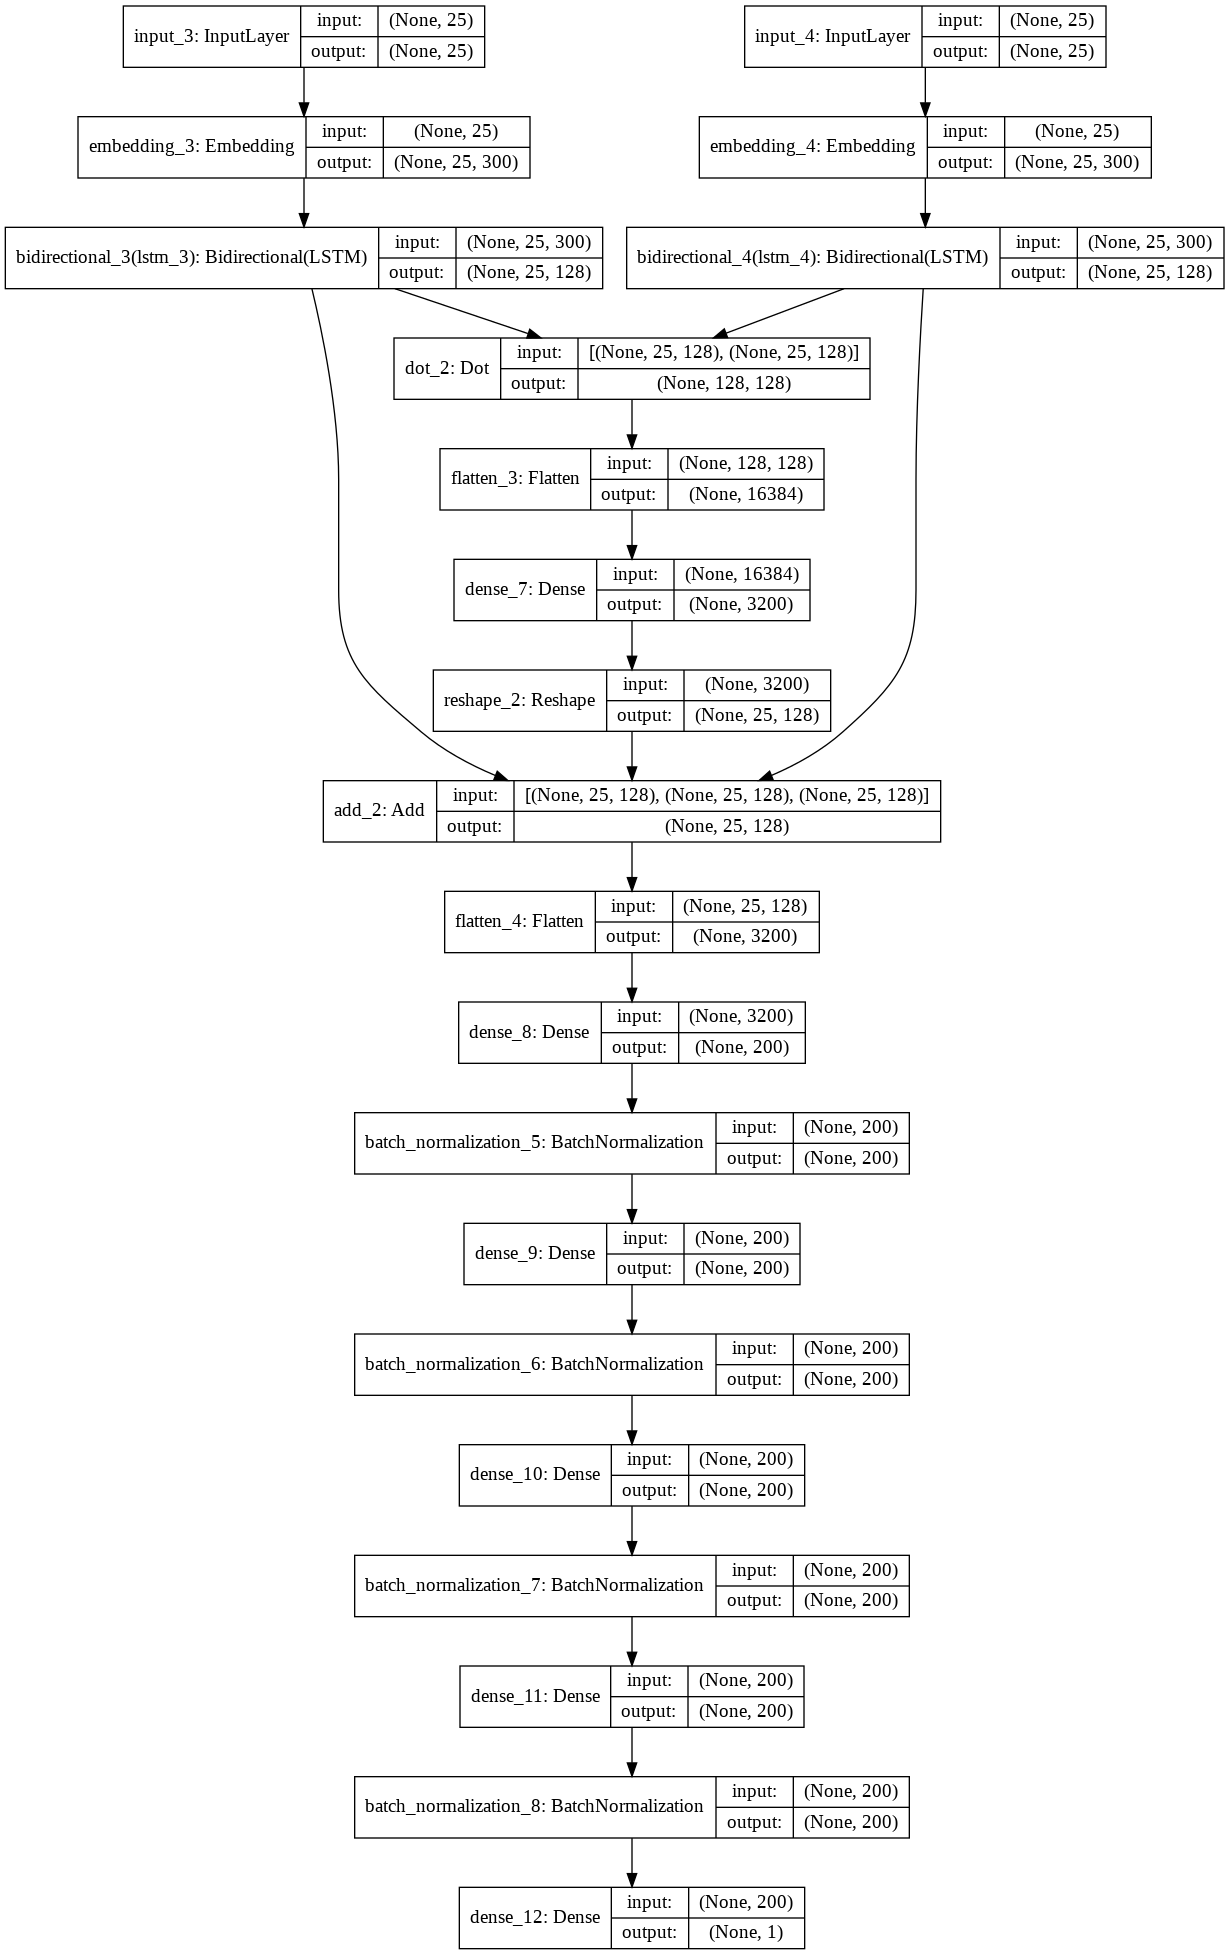

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/NLP/model_plot.png',show_shapes=True, show_layer_names=True)

In [0]:
t0 = time.time()
callbacks = [ModelCheckpoint('/content/drive/My Drive/NLP/weights/model_weights.h5',
                             monitor='val_acc',
                             save_best_only=True)]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=25,
                    validation_split=0.1,
                    verbose=2,
                    batch_size=516,
                    callbacks=callbacks)
t1 = time.time()

Train on 327474 samples, validate on 36387 samples
Epoch 1/25
 - 173s - loss: 0.5116 - acc: 0.7390 - val_loss: 0.4557 - val_acc: 0.7733
Epoch 2/25
 - 169s - loss: 0.4288 - acc: 0.7904 - val_loss: 0.4164 - val_acc: 0.7963
Epoch 3/25
 - 169s - loss: 0.3805 - acc: 0.8192 - val_loss: 0.4017 - val_acc: 0.8097
Epoch 4/25
 - 170s - loss: 0.3364 - acc: 0.8446 - val_loss: 0.3998 - val_acc: 0.8142
Epoch 5/25
 - 171s - loss: 0.2910 - acc: 0.8692 - val_loss: 0.3966 - val_acc: 0.8161
Epoch 6/25
 - 173s - loss: 0.2450 - acc: 0.8930 - val_loss: 0.4157 - val_acc: 0.8230
Epoch 7/25
 - 172s - loss: 0.2005 - acc: 0.9148 - val_loss: 0.4629 - val_acc: 0.8241
Epoch 8/25
 - 172s - loss: 0.1608 - acc: 0.9332 - val_loss: 0.4891 - val_acc: 0.8235
Epoch 9/25
 - 171s - loss: 0.1310 - acc: 0.9466 - val_loss: 0.5374 - val_acc: 0.8231
Epoch 10/25
 - 171s - loss: 0.1062 - acc: 0.9580 - val_loss: 0.5938 - val_acc: 0.8223
Epoch 11/25
 - 171s - loss: 0.0880 - acc: 0.9656 - val_loss: 0.6005 - val_acc: 0.8270
Epoch 12/25


In [0]:
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Minutes elapsed: 71.598131


# Evaluation

In [0]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})

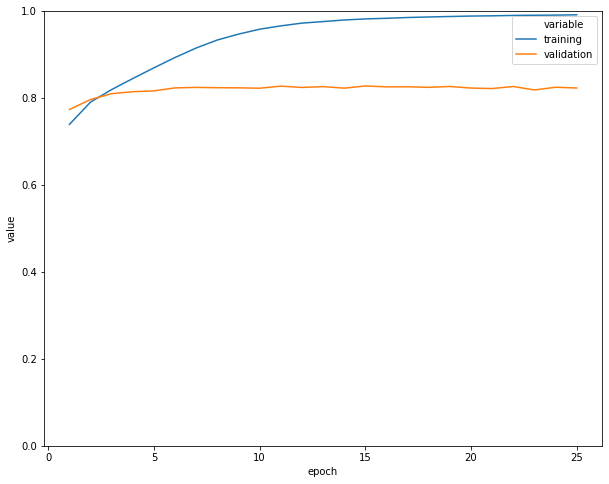

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.ylim(0, 1)
sns.lineplot(x="epoch", y="value",hue='variable', data=pd.melt(acc, ['epoch']))

In [0]:
# print best validation accuracy and epoch

max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 15 = 0.8274


In [0]:
# load model weights and evaluate once on the test score

model.load_weights('/content/drive/My Drive/NLP/weights/model_weights.h5')
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.7269, accuracy = 0.8282
